### 正则化在损失函数中引入模型复杂度指标，利用给W加权值，弱化了训练数据的噪声(一般不正则化b)
### loss = loss(y与y_) + REGULARIZER * loss(w)
### 其中，
### 1) loss(y与y_)：是模型中所有参数的损失函数，如：交叉熵，均方误差
### 2) REGULARIZER：用超参数REGULARIZER给出参数w在总loss中的比例，即正则化的权重
### 3) loss(w)：需要正则化的参数

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('dot.csv')
x_data = np.array(df[['x1', 'x2']])
y_data = np.array(df['y_c'])

x_train = np.vstack(x_data).reshape(-1,2)
y_train = np.vstack(y_data).reshape(-1,1)

Y_c = [['red' if y else 'blue'] for y in y_train]

In [3]:
x_train = tf.cast(x_train, tf.float32)
y_train = tf.cast(y_train, tf.float32)

In [4]:
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)

In [5]:
w1 = tf.Variable(tf.random.normal([2, 11]), dtype=tf.float32)
b1 = tf.Variable(tf.constant(0.01, shape=[11]))

w2 = tf.Variable(tf.random.normal([11, 1]), dtype=tf.float32)
b2 = tf.Variable(tf.constant(0.01, shape=[1]))

lr = 0.01
epoch = 800

In [6]:
for epoch in range(epoch):
    for step, (x_train, y_train) in enumerate(train_db):
        with tf.GradientTape() as tape:  # 记录梯度信息

            h1 = tf.matmul(x_train, w1) + b1  # 记录神经网络乘加运算
            h1 = tf.nn.relu(h1)
            y = tf.matmul(h1, w2) + b2

            # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_mse = tf.reduce_mean(tf.square(y_train - y))
            # 添加l2正则化
            loss_regularization = []
            # tf.nn.l2_loss(w)=sum(w ** 2) / 2
            loss_regularization.append(tf.nn.l2_loss(w1))
            loss_regularization.append(tf.nn.l2_loss(w2))
            # 求和
            # 例：x=tf.constant(([1,1,1],[1,1,1]))
            #   tf.reduce_sum(x)
            # >>>6
            # loss_regularization = tf.reduce_sum(tf.stack(loss_regularization))
            loss_regularization = tf.reduce_sum(loss_regularization)
            loss = loss_mse + 0.03 * loss_regularization #REGULARIZER = 0.03

        # 计算loss对各个参数的梯度
        variables = [w1, b1, w2, b2]
        grads = tape.gradient(loss, variables)

        # 实现梯度更新
        # w1 = w1 - lr * w1_grad
        w1.assign_sub(lr * grads[0])
        b1.assign_sub(lr * grads[1])
        w2.assign_sub(lr * grads[2])
        b2.assign_sub(lr * grads[3])

    # 每200个epoch，打印loss信息
    if epoch % 20 == 0:
        print('epoch:', epoch, 'loss:', float(loss))

epoch: 0 loss: 0.8466874957084656
epoch: 20 loss: 0.2521463930606842
epoch: 40 loss: 0.21713823080062866
epoch: 60 loss: 0.19417652487754822
epoch: 80 loss: 0.1758977323770523
epoch: 100 loss: 0.15967607498168945
epoch: 120 loss: 0.1459168642759323
epoch: 140 loss: 0.13468948006629944
epoch: 160 loss: 0.12521418929100037
epoch: 180 loss: 0.11751632392406464
epoch: 200 loss: 0.11077212542295456
epoch: 220 loss: 0.10364515334367752
epoch: 240 loss: 0.09887232631444931
epoch: 260 loss: 0.09536384791135788
epoch: 280 loss: 0.09245584905147552
epoch: 300 loss: 0.09009568393230438
epoch: 320 loss: 0.0881105437874794
epoch: 340 loss: 0.08646281808614731
epoch: 360 loss: 0.0849636048078537
epoch: 380 loss: 0.0837101936340332
epoch: 400 loss: 0.08257213234901428
epoch: 420 loss: 0.08166047930717468
epoch: 440 loss: 0.08093777298927307
epoch: 460 loss: 0.08032219111919403
epoch: 480 loss: 0.07968068867921829
epoch: 500 loss: 0.07909936457872391
epoch: 520 loss: 0.078431636095047
epoch: 540 loss:

In [7]:
print("*******predict*******")
# xx在-3到3之间以步长为0.01，yy在-3到3之间以步长0.01,生成间隔数值点
xx, yy = np.mgrid[-3:3:.01, -3:3:.01]
# 将xx , yy拉直，并合并配对为二维张量，生成二维坐标点
grid = np.c_[xx.ravel(), yy.ravel()]
grid = tf.cast(grid, tf.float32)
# 将网格坐标点喂入神经网络，进行预测，probs为输出
probs = []
print(grid)

*******predict*******
tf.Tensor(
[[-3.   -3.  ]
 [-3.   -2.99]
 [-3.   -2.98]
 ...
 [ 2.99  2.97]
 [ 2.99  2.98]
 [ 2.99  2.99]], shape=(360000, 2), dtype=float32)


In [8]:
for x_test in grid:
    # 使用训练好的参数进行预测
    h1 = tf.matmul([x_test], w1) + b1
    h1 = tf.nn.relu(h1)
    y = tf.matmul(h1, w2) + b2  # y为预测结果
    probs.append(y)

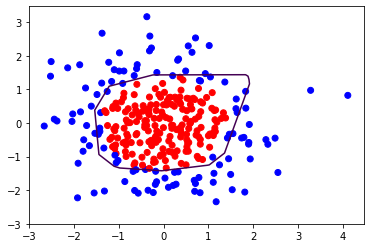

In [9]:
# 取第0列给x1，取第1列给x2
x1 = x_data[:, 0]
x2 = x_data[:, 1]
# probs的shape调整成xx的样子
probs = np.array(probs).reshape(xx.shape)
plt.scatter(x1, x2, color=np.squeeze(Y_c)) #squeeze去掉纬度是1的纬度,相当于去掉[['red'],[''blue]],内层括号变为['red','blue']
# 把坐标xx yy和对应的值probs放入contour<[‘kɑntʊr]>函数，给probs值为0.5的所有点上色  plt点show后 显示的是红蓝点的分界线
plt.contour(xx, yy, probs, levels=[.5])